In [1]:
%%time
import MDAnalysis as mda
import numpy as np
import os,sys

CPU times: user 1.63 s, sys: 1.38 s, total: 3.01 s
Wall time: 1.15 s


In [8]:
# dp
data_path1='/home/jxhe/works/dp-cnt/cnt-dpmd-data/8-8-8'
trjtpr1=data_path1 + "/cnt.tpr"
trjxtc1=data_path1 + "/8-8-8.xtc"
# amber
data_path2='/home/jxhe/works/dp-cnt/cnt-dpmd-data/8-8-8b'
trjtpr2=data_path2 + "/amber.data"
trjxtc2=data_path2 + "/03_nvt.lammpstrj"
outdir = '/home/jxhe/works/dp-cnt/cnt-dpmd-data/01_radius/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("outdir:", outdir)

outdir: /home/jxhe/works/dp-cnt/cnt-dpmd-data/01_radius/


In [16]:
u1 = mda.Universe(trjtpr1,trjxtc1)
u2 = mda.Universe(trjtpr2,trjxtc2,format="LAMMPSDUMP")
total_frames1 = len(u1.trajectory)
print(f"Total frames in the trajectory dp: {total_frames1}")
total_frames2 = len(u2.trajectory)
print(f"Total frames in the trajectory amber: {total_frames2}")

Total frames in the trajectory dp: 4000
Total frames in the trajectory amber: 4001


In [17]:
# 获取相关原子组
water_HT = u1.select_atoms('type HT')
water_OT = u1.select_atoms('type OT')
cnt_c_atoms = u1.select_atoms('resname CNT and name C')
cnt_h_atoms = u1.select_atoms('resname CNT and name H')

# 计算CNT C原子的z坐标平均值
z_mean1 = cnt_c_atoms.positions[:,2].mean()

# 根据z坐标的平均值分割CNT H原子为上下两组
cnt_up_h_atoms = u1.select_atoms(f'resname CNT and name H and prop z > {z_mean1}')
cnt_down_h_atoms= u1.select_atoms(f'resname CNT and name H and prop z <= {z_mean1}')

# 计算上下两组H原子的z坐标平均值
z_up1 = cnt_up_h_atoms.positions[:,2].mean()+2
z_down1 = cnt_down_h_atoms.positions[:,2].mean()+2
print(z_up)
print(z_down)

33.06339454650879
14.127391815185547


In [18]:
# 获取相关原子组
amber_HT = u2.select_atoms('type 3')
amber_OT = u2.select_atoms('type 4')
amber_c_atoms = u2.select_atoms('type 1')
amber_h_atoms = u2.select_atoms('type 2')

# 计算CNT C原子的z坐标平均值
z_mean2 = amber_c_atoms.positions[:,2].mean()

# 根据z坐标的平均值分割CNT H原子为上下两组
amber_up_h_atoms = u2.select_atoms(f'type 2 and prop z > {z_mean2}')
amber_down_h_atoms= u2.select_atoms(f'type 2 and prop z <= {z_mean2}')

# 计算上下两组H原子的z坐标平均值
z_up2 = amber_up_h_atoms.positions[:,2].mean()+2
z_down2 = amber_down_h_atoms.positions[:,2].mean()+2
print(z_up)
print(z_down)

33.06339454650879
14.127391815185547


# dp

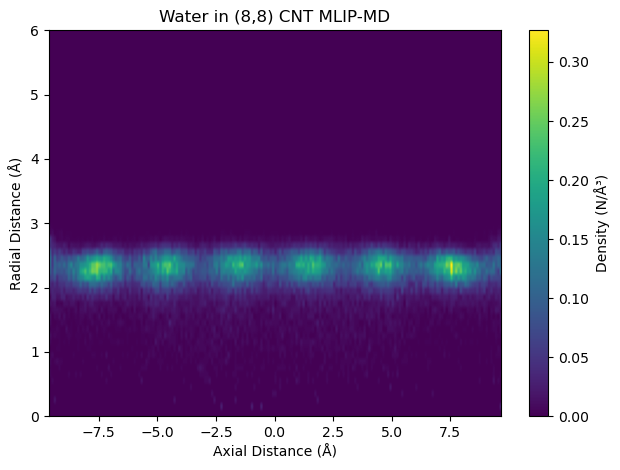

In [27]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

#用法 python dpdrdxden.py xxxtpr xxxxtc csv_name
u1 = mda.Universe(trjtpr1,trjxtc1)

def plot_water_density_around_CNT_dp(u, figure_title, csv_name):
    o_atoms = u.select_atoms('type OT')
    cnt_c_atoms = u.select_atoms('resname CNT and name C')

    z_mean = cnt_c_atoms.positions[:, 2].mean()
    cnt_up_h_atoms = u.select_atoms(f'resname CNT and name H and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'resname CNT and name H and prop z <= {z_mean}')

    z_length = cnt_up_h_atoms.positions[:, 2].mean() - cnt_down_h_atoms.positions[:, 2].mean()
    z_center_z = (cnt_up_h_atoms.positions[:, 2].mean() + cnt_down_h_atoms.positions[:, 2].mean()) / 2
    z_up = z_center_z + z_length / 2
    z_down = z_center_z - z_length / 2

    r_max = 6.0
    dr = 0.1
    dz = 0.1

    r_bins = np.arange(0, r_max + dr, dr)
    z_bins = np.arange(z_down, z_up + dz, dz)

    density = np.zeros((len(z_bins) - 1, len(r_bins) - 1))

    cnt_center_xy = cnt_c_atoms.positions[:, :2].mean(axis=0)

    for ts in u.trajectory[5:3000]:
        o_positions = o_atoms.positions.copy()
        o_positions[:, :2] -= cnt_center_xy

        radial_dists = np.sqrt(o_positions[:, 0]**2 + o_positions[:, 1]**2)
        axial_dists = o_positions[:, 2]

        for i, z in enumerate(z_bins[:-1]):
            z_next = z_bins[i + 1]
            axial_mask = (axial_dists >= z) & (axial_dists < z_next)

            for j, r in enumerate(r_bins[:-1]):
                r_next = r_bins[j + 1]
                radial_mask = (radial_dists >= r) & (radial_dists < r_next)

                mask = axial_mask & radial_mask

                ring_volume = np.pi * (r_next**2 - r**2) * dz
                density[i, j] += (mask.sum() / ring_volume)

    density /= len(u.trajectory)
    
    np.savetxt(csv_name, density, delimiter=",")
    return density

plt.imshow(density.T, extent=(-z_length/2, +z_length/2, 0, r_max), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Density (N/Å³)')
plt.xlabel('Axial Distance (Å)')
plt.ylabel('Radial Distance (Å)')
plt.title(figure_title)
plt.tight_layout()

# Save the figure with the provided title
plt.savefig(f"{figure_title}.svg", transparent=True)
plt.show()

figure_title1="Water in (8,8) CNT MLIP-MD"
plot_water_density_around_CNT_dp(u1, figure_title1)


# amber

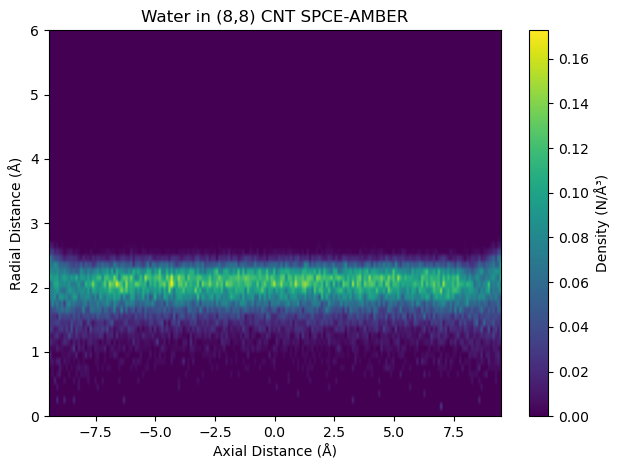

In [28]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

def plot_water_density_around_CNT_amber(u, figure_title):
    o_atoms = u.select_atoms('type 4')
    cnt_c_atoms = u.select_atoms('type 1')

    z_mean = cnt_c_atoms.positions[:, 2].mean()
    cnt_up_h_atoms = u.select_atoms(f'type 2 and prop z > {z_mean}')
    cnt_down_h_atoms = u.select_atoms(f'type 2 and prop z <= {z_mean}')

    z_length = cnt_up_h_atoms.positions[:, 2].mean() - cnt_down_h_atoms.positions[:, 2].mean()
    z_center_z = (cnt_up_h_atoms.positions[:, 2].mean() + cnt_down_h_atoms.positions[:, 2].mean()) / 2
    z_up = z_center_z + z_length / 2
    z_down = z_center_z - z_length / 2

    r_max = 6.0
    dr = 0.1
    dz = 0.1

    r_bins = np.arange(0, r_max + dr, dr)
    z_bins = np.arange(z_down, z_up + dz, dz)

    density = np.zeros((len(z_bins) - 1, len(r_bins) - 1))

    cnt_center_xy = cnt_c_atoms.positions[:, :2].mean(axis=0)

    for ts in u.trajectory[5:3000]:
        o_positions = o_atoms.positions.copy()
        o_positions[:, :2] -= cnt_center_xy

        radial_dists = np.sqrt(o_positions[:, 0]**2 + o_positions[:, 1]**2)
        axial_dists = o_positions[:, 2]

        for i, z in enumerate(z_bins[:-1]):
            z_next = z_bins[i + 1]
            axial_mask = (axial_dists >= z) & (axial_dists < z_next)

            for j, r in enumerate(r_bins[:-1]):
                r_next = r_bins[j + 1]
                radial_mask = (radial_dists >= r) & (radial_dists < r_next)

                mask = axial_mask & radial_mask

                ring_volume = np.pi * (r_next**2 - r**2) * dz
                density[i, j] += (mask.sum() / ring_volume)

    density /= len(u.trajectory)
    
    np.savetxt(csv_name, density, delimiter=",")
    return density

    plt.imshow(density.T, extent=(-z_length/2, +z_length/2, 0, r_max), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Density (N/Å³)')
    plt.xlabel('Axial Distance (Å)')
    plt.ylabel('Radial Distance (Å)')
    plt.title(figure_title)
    plt.tight_layout()
    
    # Save the figure with the provided title
    plt.savefig(f"{figure_title}.svg",transparent=True)
    plt.show()

# figure_title1="Water in (8,8) CNT (MLIP)"
figure_title2="Water in (8,8) CNT SPCE-AMBER"
plot_water_density_around_CNT_amber(u2,figure_title2)